<a href="https://colab.research.google.com/github/rileythejones/DS-Unit-2-Linear-Models/blob/master/RJ_assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Watch Aaron's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [13]:
df.shape

(421, 59)

In [0]:
df.info()

In [0]:
df.drop()

Seeing as most of the columns are filled with null values, I'll assemble a new dataframe from the non-null columns, rather than drop ones from the original dataframe. . 

Here, I think it's more important to determine the significance of features that we can understand rather than make correct predictions that do not advance understanding.  

In [0]:
dd = df[['Burrito', 'Date', 'Cost', 'Hunger', 'Wrap', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Great']]

In [58]:
dd.shape

(421, 14)

In [59]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 14 columns):
Burrito         421 non-null object
Date            421 non-null object
Cost            414 non-null float64
Hunger          418 non-null float64
Wrap            418 non-null float64
Tortilla        421 non-null float64
Temp            401 non-null float64
Meat            407 non-null float64
Fillings        418 non-null float64
Meat:filling    412 non-null float64
Uniformity      419 non-null float64
Salsa           396 non-null float64
Synergy         419 non-null float64
Great           421 non-null bool
dtypes: bool(1), float64(11), object(2)
memory usage: 66.5+ KB


I understand what these features mean, it makes sense to impute NaN values with the averages for the column. 



In [60]:
dd.T.head(14)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422
Burrito,California,California,Carnitas,Asada,California,Other,California,Carnitas,California,Asada,Surf & Turf,Other,California,Other,California,California,Surf & Turf,Other,Other,California,California,Other,Other,California,California,Other,Asada,Other,Other,Other,Asada,Other,Other,Asada,California,California,Other,Other,California,Asada,...,Other,California,California,California,Other,California,Other,Asada,Carnitas,Carnitas,Carnitas,California,California,Other,Other,Carnitas,Carnitas,California,Surf & Turf,California,California,California,Carnitas,Carnitas,Other,Other,Other,Other,Other,California,California,Other,Asada,Other,California,Other,Other,California,Other,Other
Date,1/18/2016,1/24/2016,1/24/2016,1/24/2016,1/27/2016,1/28/2016,1/30/2016,1/30/2016,2/1/2016,2/6/2016,2/6/2016,2/11/2016,2/11/2016,2/11/2016,2/11/2016,2/12/2016,2/12/2016,2/14/2016,2/14/2016,2/17/2016,2/17/2016,2/24/2016,2/24/2016,2/28/2016,2/28/2016,2/29/2016,2/29/2016,3/3/2016,3/3/2016,3/3/2016,3/8/2016,3/8/2016,3/11/2016,3/11/2016,3/14/2016,3/14/2016,3/14/2016,3/14/2016,3/17/2016,3/18/2016,...,12/16/2017,12/29/2017,12/29/2017,1/2/2018,1/9/2018,1/12/2018,1/12/2018,4/4/2018,4/9/2018,4/9/2018,4/9/2018,4/14/2018,4/14/2018,4/16/2018,4/16/2018,4/20/2018,4/20/2018,4/21/2018,4/21/2018,4/29/2018,4/29/2018,5/1/2018,5/7/2018,5/7/2018,5/22/2018,5/22/2018,5/22/2018,5/22/2018,5/22/2018,11/6/2018,8/24/2019,8/27/2019,8/27/2019,8/27/2019,8/27/2019,8/27/2019,8/27/2019,8/27/2019,8/27/2019,8/27/2019
Cost,6.49,5.45,4.85,5.25,6.59,6.99,7.19,6.99,9.25,6.25,9.5,6.95,6.25,6.99,6.25,7.49,8.49,5.99,5.99,6.4,6.4,8.75,5.5,7.49,7.49,6,7,6.29,6.49,6.49,6.6,7.65,5,5,6.25,6.25,6.25,9.5,7.84,7.89,...,11.5,7.89,7.89,7.25,4.19,7,8.5,7.2,5.99,5.99,5.99,8.99,8.99,5.99,7.5,5.99,5.99,8.5,9.5,8.5,8.5,6.99,5.99,5.99,9.99,9.99,7.39,7.39,7.39,8,8,5.5,6.75,6,7.9,6,6,7.9,7.9,5.5
Hunger,3,3.5,1.5,2,4,4,1.5,4,3.5,3.5,2,2,3.5,3,3,4,2.5,3,2,4,2.5,3.5,2.5,2.5,2.5,3.5,3.5,3.5,4.5,4.5,3.5,3.5,3.5,1,0.5,3,3.75,3,4,1,...,3.5,4,5,4,3,5,4,3,3,3.5,2,4,4,3.5,4,3,5,3.2,3,3.2,3,4,3.5,3.5,5,4,4,4.5,4,4,4,2,3,3,2,1,4,3,3,3.5
Wrap,4,5,5,5,4,1,3,3,2,4.5,3.5,1,4,5,4,4.5,2,4.5,1.5,5,4.5,4,4.5,3,4.5,1.5,3.5,4,4,4,1,4,NaN,4,5,5,5,3.5,4.5,5,...,2,4.5,3,5,4,5,1,4,2,4,2,3,1.5,2.5,4.5,1.5,3.5,5,5,4,5,4.5,4,NaN,4.5,3,5,4,4,5,5,4.5,5,4.5,5,5,3,4.5,2,4
Tortilla,3,2,3,3,4,3,2,2.5,2,2.5,2.5,3,3,3,4,3,4,4,3.5,3,3.5,1.5,1.5,4,3,2.5,2.5,3.5,3,3,4,3,2,2,3,3.5,3,3,4,3,...,2,4,5,4,3,5,4,4,3.5,4,2,4.5,4.5,4,4,2,4,3.8,3.5,3.5,3,3.5,2.5,4,4,5,5,3.5,3,5,4,4.5,3,4,4.5,5,4,4,5,3
Temp,5,3.5,2,2,5,4,3,3,4.5,1.5,2.5,4,3.5,1,NaN,2.5,4,4,4,4,3,2,2.5,3,2,2.5,3,5,5,4.5,2,1.5,NaN,NaN,5,5,5,3,4,3.5,...,2,3,5,5,5,5,4,5,5,4.5,3.5,4.5,5,4.5,4,5,4.5,4,3,1,2.5,3,3,4,4,5,4,4.5,5,5,4.5,5,4,4,3,4,5,4,2,5
Meat,3,2.5,2.5,3.5,4,5,3,3,4.5,1.5,2.75,4,3.5,1.5,2,4,4.5,3,3.5,2.75,3,3,3.5,4,4.5,3,3,4,4,3.5,4,3,2.5,1,4,2.5,5,4,3.5,4.5,...,4,4,5,4,2,5,3,4,4.3,5,4.5,4,3.5,3.5,3.5,4.5,3.5,4,3.8,3,3.5,3.2,4,4.5,3,3,4,4,NaN,5,3.5,5,4,4.5,4,3.5,NaN,4,5,4.3
Fillings,3.5,2.5,3,3,3.5,3.5,2,2.5,3.5,3,2.5,3,4,2.5,2,4,4,3.5,NaN,3,3,3.5,3,4,4,4,4,4,4,3.5,3.5,3,2,1,2.75,2.5,4.5,3,4,4,...,3.5,4,5,5,2,5,3.5,3,3.5,4.5,4,4,4,3,4.2,3.5,4,4,4,3,3,3.2,3.5,4,3,3,3,3.5,3,4.5,4,3.5,3,4,4.5,NaN,3.5,3.7,5,4
Meat:filling,4,2,4.5,4,4.5,2.5,2.5,3,1.5,4.5,2.5,4,2,4,4,3.5,5,4,4,4,4,4,4,4,4,4,2,3.5,5,3.5,4.5,2.5,2,0.5,4,4,4,3.5,4.5,5,...,3,3,4,5,4,5,1,3,5,5,4,3,4,4.5,4.5,4.5,4,3.8,3.8,3.4,1,3.2,2.5,4.5,5,4,4,2,NaN,5,4,4,4,3,2.5,4,4,3,5,4.9


In [0]:
dd['Date'] = pd.to_datetime(dd['Date'])
train = dd[dd['Date'].dt.year <= 2016].drop(columns='Date')
val = dd[dd['Date'].dt.year == 2017].drop(columns='Date')
test = dd[dd['Date'].dt.year >= 2018].drop(columns='Date')
train.shape, val.shape, test.shape

In [0]:
target = 'Great'
features = dd.drop(columns=[target, 'Date']).columns


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [86]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((298, 12), (298,), (85, 12), (85,), (38, 12), (38,))

In [87]:
train['Great'].value_counts(normalize=True), val['Great'].value_counts(normalize=True), test['Great'].value_counts(normalize=True)

(False    0.590604
 True     0.409396
 Name: Great, dtype: float64, False    0.552941
 True     0.447059
 Name: Great, dtype: float64, True     0.578947
 False    0.421053
 Name: Great, dtype: float64)

In [88]:
X_train.head()

,Burrito,Cost,Hunger,Wrap,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy
0,California,6.49,3.0,4.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0
1,California,5.45,3.5,5.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5
2,Carnitas,4.85,1.5,5.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0
3,Asada,5.25,2.0,5.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0
4,California,6.59,4.0,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5


In [0]:
import category_encoders as ce 

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)

In [0]:
X_train_encoded = encoder.fit_transform(X_train) 
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test) 

In [92]:
X_train_encoded.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Wrap,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy
0,1,0,0,0,0,6.49,3.0,4.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0
1,1,0,0,0,0,5.45,3.5,5.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5
2,0,1,0,0,0,4.85,1.5,5.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0
3,0,0,1,0,0,5.25,2.0,5.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0
4,1,0,0,0,0,6.59,4.0,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5


In [0]:
from sklearn.impute import SimpleImputer 

In [0]:
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed= imputer.transform(X_val_encoded)
X_test_imputed= imputer.transform(X_test_encoded)  

In [100]:
X_train_imputed[:5]

array([[1.  , 0.  , 0.  , 0.  , 0.  , 6.49, 3.  , 4.  , 3.  , 5.  , 3.  ,
        3.5 , 4.  , 4.  , 4.  , 4.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 5.45, 3.5 , 5.  , 2.  , 3.5 , 2.5 ,
        2.5 , 2.  , 4.  , 3.5 , 2.5 ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 4.85, 1.5 , 5.  , 3.  , 2.  , 2.5 ,
        3.  , 4.5 , 4.  , 3.  , 3.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 5.25, 2.  , 5.  , 3.  , 2.  , 3.5 ,
        3.  , 4.  , 5.  , 4.  , 4.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 6.59, 4.  , 4.  , 4.  , 5.  , 4.  ,
        3.5 , 4.5 , 5.  , 2.5 , 4.5 ]])

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)




In [0]:
# regularzied log reg model 
from sklearn.linear_model import LogisticRegressionCV

In [0]:
model = LogisticRegressionCV()

In [0]:
model.fit(X_train_scaled, y_train)

In [111]:
model.score(X_train_scaled, y_train)

0.8926174496644296

In [106]:
# validate
model.score(X_val_scaled, y_val)

0.8705882352941177

In [0]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)

In [108]:
coefficients

Burrito_California     0.137346
Burrito_Carnitas       0.021533
Burrito_Asada         -0.006688
Burrito_Other         -0.083321
Burrito_Surf & Turf   -0.114737
Cost                   0.218151
Hunger                 0.106680
Wrap                   0.072066
Tortilla               0.328156
Temp                   0.266630
Meat                   0.580211
Fillings               0.573062
Meat:filling           0.501488
Uniformity             0.182172
Salsa                  0.251815
Synergy                0.669432
dtype: float64

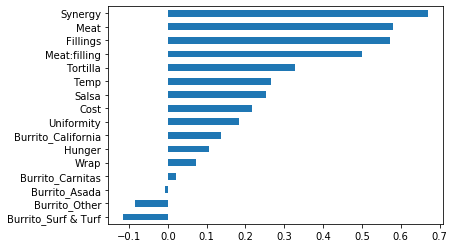

In [109]:

%matplotlib inline
coefficients.sort_values().plot.barh();

In [110]:
# test 
model.score(X_test_scaled, y_test)

0.7631578947368421

In [114]:
# baseline was 
y_test.value_counts(normalize=True)

True     0.578947
False    0.421053
Name: Great, dtype: float64